In [1]:
# sandy code stuff and data access from illustris

In [25]:
import illustris_python as il
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

 Define the basepath for the data (modify as needed -- (look into this as to where it is best to load from)), load the total masses and star formation rate within twice the stellar half mass radius of all the Subfind subhalos

In [3]:
cd

/home/desi


In [4]:
basePath = '/home/desi/Illustris-3/output'
fields = ['SubhaloMass', 'SubhaloSFRinRad']
subhalos = il.groupcat.loadSubhalos(basePath, 135, fields=fields)

Inspecting the return, we see it is a dict/hash/struct with a key 'count' indicating that there are 121209 total subhalos. Each requested fielf is returned as a numeric array with a key name equal to its field name in the group catalog

In [5]:
subhalos.keys()

dict_keys(['count', 'SubhaloMass', 'SubhaloSFRinRad'])

In [6]:
subhalos['SubhaloMass'].shape

(121209,)

Make a scatterplot of the relation

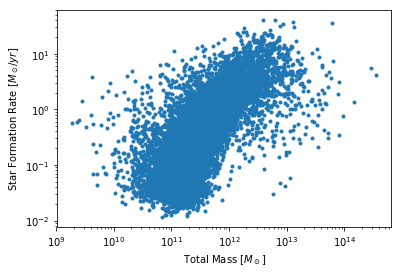

In [34]:
mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704
plt.plot(mass_msun,subhalos['SubhaloSFRinRad'],'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')
plt.savefig('scatterplot.png')

In [8]:
## Get a list of primary subhalo IDs by loading the GroupFirstSub field from the FoF groups
GroupFirstSub = il.groupcat.loadHalos(basePath,135,fields=['GroupFirstSub'])
GroupFirstSub.dtype

dtype('uint32')

In [9]:
GroupFirstSub.shape

(131727,)

For the 5 most massive central subhalos, let's load all their fields from the group catalog and print a gas fraction (gas mass over total baryonic mass) in the stellar half mass radius. 

In [10]:
ptNumGas = il.snapshot.partTypeNum('gas') # 0
ptNumStars = il.snapshot.partTypeNum('stars') # 4
for i in range(5):
    all_fields = il.groupcat.loadSingle(basePath,135,subhaloID=GroupFirstSub[i])
    gas_mass   = all_fields['SubhaloMassInHalfRadType'][ptNumGas]
    stars_mass = all_fields['SubhaloMassInHalfRadType'][ptNumStars]
    frac = gas_mass / (gas_mass + stars_mass)
    print(GroupFirstSub[i], frac)

0 0.06888455
608 0.023693658
1030 0.06385147
1396 0.003577049
1801 0.12220047


### Reading individual sub-trees from the full merger trees with 'offsets'
##### Make use of the pre-computed offsets to accelerate the reading of subsets of the full merger tree files.
The load tree function requires that you have already downloaded the corresponding group catalogs corresponding to the snapshot of the subhalo.
Extract the total mass, Subfind ID, and snapshot along the main progenitor branch. Plot the mass histories.

Text(0, 0.5, 'Total Subhalo Mass [code units]')

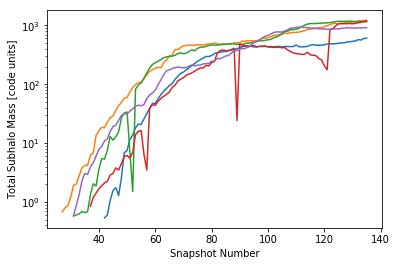

In [11]:
fields = ['SubhaloMass', 'SubfindID', 'SnapNum']
start = 100
for i in range(start,start+5):
    tree = il.sublink.loadTree(basePath,135,GroupFirstSub[i],fields=fields,onlyMPB=True)
    plt.plot(tree['SnapNum'], tree['SubhaloMass'], '-')
plt.yscale('log')
plt.xlabel('Snapshot Number')
plt.ylabel('Total Subhalo Mass [code units]')

Note that the single-snapshot dips seen in the green and red curves can sometimes occur due to the 'subhalo switching problem'. The downward trend in mass followed by the sudden increase in the cyan is a signature of a merger. 

Text(0, 0.5, 'Total Subhalo Mass [code units]')

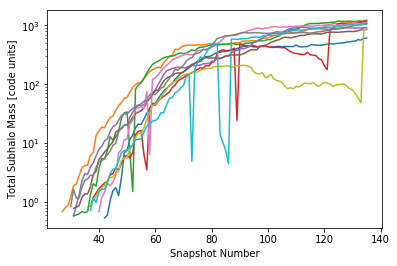

In [12]:
## do this same thing with some other catalogs ??
fields = ['SubhaloMass', 'SubfindID', 'SnapNum']
start = 100
for i in range(start,start+10):
    tree = il.sublink.loadTree(basePath,135,GroupFirstSub[i],fields=fields,onlyMPB=True)
    plt.plot(tree['SnapNum'], tree['SubhaloMass'], '-')
plt.yscale('log')
plt.xlabel('Snapshot Number')
plt.ylabel('Total Subhalo Mass [code units]')

We include a semi-complex example of walking through the tree to determine the number of past mergers of a given subhalo, above some mass ratio threshold. Here, the mass ratio is defined as the ratio of the maximum past stellar mass of the two progenitors. For the same halos as above, count the number of major mergers (mass ratio > 1/5).

In [13]:
ratio = 1.0/5.0
# the following fields are required for the walk and the mass ratio analysis
fields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID', 'FirstProgenitorID', 'SubhaloMassType']
for i in range(start,start+5):
    tree = il.sublink.loadTree(basePath,135,GroupFirstSub[i],fields=fields)
    numMergers = il.sublink.numMergers(tree,minMassRatio=ratio)
    print(GroupFirstSub[i], numMergers)

9106 4
9137 2
9151 3
9170 5
9191 2


Download full z=0 snapshot to play around with 

Load the Masses of all the gas cells in the entire box, calc their mean, converting to log solar masses

#### inside of ~/Illustris-3/output/snapdir_135: 
wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: e74bff8a3f17fa1497eb8c11243b2b87" "http://www.tng-project.org/api/Illustris-3/files/snapshot-135/?format=api"

In [39]:
fields = ['Masses']
gas_mass = il.snapshot.loadSubset(basePath,135,'gas',fields=fields)
print(np.log10( np.mean(gas_mass,dtype='double')*1e10/0.704))

OSError: Unable to open file (truncated file: eof = 148458672, sblock->base_addr = 0, stored_eof = 742113928)

Load the spatial Coordinates of all the dark matter particles in the box, and make a quick image with a 2D histogram

In [41]:
#dm_pos = il.snapshot.loadSubset(basePath,135,'dm',['Coordinates']);
#plt.hist2d(dm_pos[:,0], dm_pos[:,1], norm=mpl.colors.LogNorm(), bins=64);
#plt.xlim([0,75000])
#plt.ylim([0,75000])
#plt.xlabel('x [ckpc/h]')
#plt.ylabel('y [ckpc/h]')

Load the star particles belonging to FoF halo ID 100 (all fields). Print the minimum and maximum of all positions for each axis to check we have loaded only stars in a localized region.

In [19]:
#stars = il.snapshot.loadHalo(basePath,135,100,'stars')
#stars.keys()
#['count', u'GFM_Metals', u'SubfindVelDisp', u'GFM_InitialMass', u'Masses', u'Velocities', u'Coordinates',
# u'Potential', u'SubfindHsml', u'SubfindDensity', u'NumTracers', u'ParticleIDs', u'GFM_StellarFormationTime', 
# u'GFM_StellarPhotometrics', u'GFM_Metallicity']

#for i in range(3):
#    print(np.min(stars['Coordinates'][:,i]), np.max(stars['Coordinates'][:,i]))

#### I/O Scripts Reference

Loading from the FoF and Subfind group catalogs:

The optional fields arg always accepts a string list/array of field names, which must agree to the available datasets in the group catalog. if it is not specified, all fields will be read and returned, which could be significantly slower

In [29]:
il.groupcat

def loadSubhalos(basePath, snapNum, fields=None):
    """ Load all subhalo information from the entire group catalog for one snapshot
        (optionally restrict to a subset given by fields). """

def loadHalos(basePath, snapNum, fields=None):
    """ Load all halo information from the entire group catalog for one snapshot
       (optionally restrict to a subset given by fields). """
       
def loadHeader(basePath, snapNum):
    """ Load the group catalog header. """
    
def load(basePath, snapNum):
    """ Load complete group catalog all at once. """
    
def loadSingle(basePath, snapNum, haloID=-1, subhaloID=-1):
    """ Return complete group catalog information for one halo or subhalo. """


#### Loading particle-level data from the snapshots:
The partType arg may either be the particle type number, or one of the recognized string names, e.g. 'gas', 'stars', 'bhs', or 'dm'

In [30]:
il.snapshot

def loadSubset(basePath, snapNum, partType, fields=None):
    """ Load a subset of fields for all particles/cells of a given partType. """
        
def loadSubhalo(basePath, snapNum, id, partType, fields=None):
    """ Load all particles/cells of one type for a specific subhalo
        (optionally restricted to a subset fields). """
        
def loadHalo(basePath, snapNum, id, partType, fields=None):
    """ Load all particles/cells of one type for a specific halo
        (optionally restricted to a subset fields). """

#### Loading from the SubLink merger trees:

If onlyMPB = True, then only the main progenitor branch will be uploaded

In [31]:
il.sublink 

def loadTree(basePath, snapNum, id, fields=None, onlyMPB=False):
    """ Load portion of Sublink tree, for a given subhalo, in its existing flat format.
        (optionally restricted to a subset fields). """
        
def numMergers(tree, minMassRatio=1e-10, massPartType='stars', index=0):
    """ Calculate the number of mergers in this sub-tree (optionally above some mass ratio threshold). """

#### Loading from the LHaloTree merger trees:

In [32]:
il.lhalotree

def loadTree(basePath, snapNum, id, fields=None, onlyMPB=False):
    """ Load portion of LHaloTree, for a given subhalo, re-arranging into a flat format. """

#### General utility functions:

In [33]:
il.util

def partTypeNum(partType):
    """ Mapping between common names and numeric particle types. """